In [0]:
from sklearn.datasets import load_breast_cancer  # 데이터셋 로드
from sklearn.model_selection import train_test_split  # 훈련셋이랑 검증셋 분리

In [0]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
# 데이터 분할
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y, stratify=y, test_size=0.2, random_state=42)

In [3]:
x_train , x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))  # val : validation set

364 91


In [4]:
from sklearn.linear_model import SGDClassifier

# 검증 세트 사용해 모델 평가하기
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

데이터의 스케일? 

특성이 가지고 있는 값의 범위를 말함. 특성의 스케일을 전처리 하는 것을 스케일을 조정한다는 표현으로 사용.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

['mean perimeter' 'mean area']


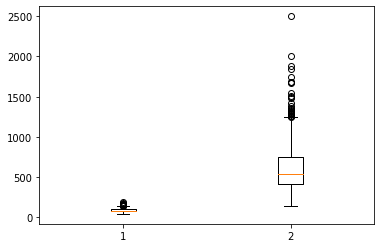

In [6]:
print(cancer.feature_names[[2,3]])
# 박스플롯
plt.boxplot(x_train[:, 2:4])  # 2에서 4행의 모든 열
plt.show()

두 특성의 스케일은 차이가 크다(100 ~ 200 과 200 ~ 2,000)

In [0]:
class SingleLayer:
    def __init__(self, learning_rate=0.1):
        self.w = None  # weight 가중치
        self.b = None  # bias 바이어스
        self.losses = []  # 손실을 누적
        self.w_history = []  # 가중치 변화 누적하는 리스트
        self.lr = learning_rate  # 학습률(hyperparameter)

    def forpass(self, x):
        # 정방향 진행
        z = np.sum(x * self.w) + self.b
        return z

    def backprop(self, x, error):
        # 역방향 진행
        w_g = x * error
        b_g = 1 * error
        return w_g, b_g

    def add_bias(self, x):
        # 1로 채워진 열백터를 추가하는. 
        return np.c_[np.ones((x.shape[0], 1)), x]

    def activation(self, z):
        # 활성화 함수
        a = 1 / (1 + np.exp(-z))
        return a 

    def fit(self, x, y, epochs=100):
        # 가중치랑 바이어스를 초기화
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())  # 가중치를 복사해서 기록(numpy 배열은 복사해서 넣어줘야 함)

        np.random.seed(42)  # 무작위로 시드 지정
        for i in range(epochs):
            loss = 0
            # 인덱스 섞기
            indexs = np.random.permutation(np.arange(len(x)))
            for j in indexs:
                z = self.forpass(x[j])  # 정방향 계산
                a = self.activation(z)  # 활성화 함수 적용
                err = -(y[j] - a)  # 오차 계산
                w_grad, b_grad = self.backprop(x[j], err)  # 역방향 계산
                self.w -= self.lr * w_grad  # 학습률을 곱해서 가중치 업데이트
                self.b -= b_grad
                self.w_history.append(self.w.copy())  # 가중치 기록
                a = np.clip(a, 1e-10, 1-1e-10)  # 로그 계산을 위한 클리핑
                loss += -(y[j]*np.log(a) * (1-y[j])*np.log(1-a))
            self.losses.append(loss/len(y))  # 평균 손실 저장

    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0

    def score(self, x, y):
        return np.mean(self.predict(x)==y)

In [8]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


0.9120879120879121

스케일을 조정하지 않은 훈련세트를 사용한 모델 훈련 : 91 퍼센트

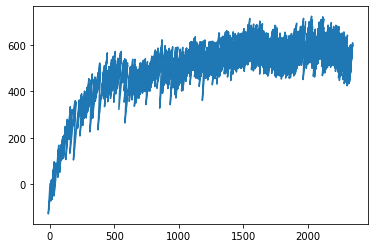

In [9]:
w2 = []  # mean perimeter 특성에 대한 가중치
w3 = []  # mean area 특성에 대한 가중치
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1])

### 스케일 조정하는 방법?

표준화
 z = (x-u)/s

In [0]:
# 표준화 구현하기, axis를 0으로 지정하면 2차원 배열의 열을 기준으로 통계치 계산 후 하나의 행 벡터로 반환. 
train_mean = np.mean(x_train, axis=0)
train_sta = np.std(x_train, axis=0)  # standard diviation
x_train_scaled = (x_train - train_mean) / train_sta

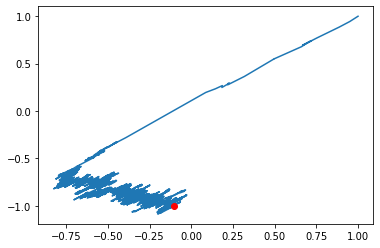

In [11]:
# 표준화된 데이터셋으로 모델 훈련하기 
ly2 = SingleLayer()
ly2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in ly2.w_history: # 다시 가중치 계산
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1],'ro') # 빨간점이 최종!

w2와 w3의 변화 비율이 비슷 > 대각선 방향으로 가중치가 이동됨. 

In [12]:
ly2.score(x_val, y_val)

0.37362637362637363

검증세트의 표준화를 거치지 않음

In [13]:
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std
# 검증세트의 표준화 완료!
ly2.score(x_val_scaled, y_val)

0.967032967032967

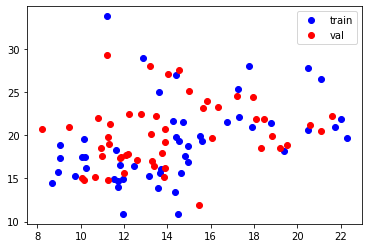

In [14]:
# 원본 훈련셋과 검증셋을 비교해보기
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')  # 훈련셋
plt.plot(x_val[:50, 0], x_val[:50, 1],'ro')  # 검증셋
plt.legend(['train', 'val'])

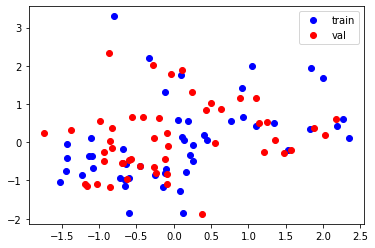

In [15]:
# 전처리된 훈련셋과 검증셋을 비교해보기
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50,1],'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50,1], 'ro')
plt.legend(['train', 'val'])

데이터 전처리를 제대로 하기?

훈련세트의 표준편차로 검증셋을 전차리 하기!

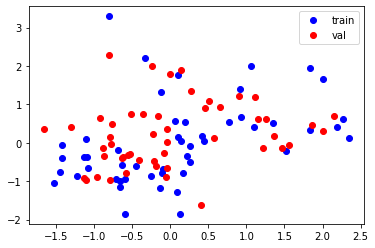

In [16]:
# 훈련세트의 평균과 표준편차로 검증셋을 전처리 했다
x_val_scaled = (x_val - train_mean) / train_sta
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50,1],'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50,1], 'ro')
plt.legend(['train', 'val'])

In [17]:
ly2.score(x_val_scaled, y_val)

0.967032967032967

# 과대적합? 과소적합??

과대적합 : 훈련세트에서만 좋은 결과를 보이는 것
과소적합 : 훈련, 검증 셋에서 모두 낮은 성능을 보이는 것

학습곡선을 통해서 볼 수 있다.
(두 경우의 정확도가 같은 곳으로 수렴해야 한다. ?

In [0]:
# Single layer 클래스에 손실함수에 대한 validation을 추가한다.

class SingleLayer_loss:
    def __init__(self, learning_rate=0.1):
        self.w = None  # weight 가중치
        self.b = None  # bias 바이어스
        self.losses = []  # 손실을 누적
        self.val_losses = [] # 검증 셋에 대한 손실을 기록
        self.w_history = []  # 가중치 변화 누적하는 리스트
        self.lr = learning_rate  # 학습률(hyperparameter)

    def forpass(self, x):
        # 정방향 진행
        z = np.sum(x * self.w) + self.b
        return z

    def backprop(self, x, error):
        # 역방향 진행
        w_g = x * error
        b_g = 1 * error
        return w_g, b_g

    def add_bias(self, x):
        # 1로 채워진 열백터를 추가하는. 
        return np.c_[np.ones((x.shape[0], 1)), x]

    def activation(self, z):
        # 활성화 함수
        a = 1 / (1 + np.exp(-z))
        return a 

    def fit(self, x, y, epochs=100, x_v=None, y_v=None):
        # 가중치랑 바이어스를 초기화
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())  # 가중치를 복사해서 기록(numpy 배열은 복사해서 넣어줘야 함)
        np.random.seed(42)  # 무작위로 시드 지정
        for i in range(epochs):
            loss = 0
            # 인덱스 섞기
            indexs = np.random.permutation(np.arange(len(x)))
            for j in indexs:
                z = self.forpass(x[j])  # 정방향 계산
                a = self.activation(z)  # 활성화 함수 적용
                err = -(y[j] - a)  # 오차 계산
                w_grad, b_grad = self.backprop(x[j], err)  # 역방향 계산
                self.w -= self.lr * w_grad  # 학습률을 곱해서 가중치 업데이트
                self.b -= b_grad
                self.w_history.append(self.w.copy())  # 가중치 기록
                a = np.clip(a, 1e-10, 1-1e-10)  # 로그 계산을 위한 클리핑
                loss += -(y[j]*np.log(a) + (1-y[j])*np.log(1-a))
            self.losses.append(loss/len(y))  # 평균 손실 저장
            self.updata_val_loss(x_v, y_v)  # 검증 셋에 대한 손실 계산

    def updata_val_loss(self, x, y):
        # 검증 셋의 손실을 계산하기
        if x is None:
            return
        val_loss = 0
        for i in range(len(x)):
            z = self.forpass(x[i])  # 정방향 계산과 활성화 함수 적용
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))  # 동일하게 손실 계산
        self.val_losses.append(val_loss/len(y))

    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0

    def score(self, x, y):
        return np.mean(self.predict(x)==y)

In [0]:
ly3 = SingleLayer_loss()
ly3.fit(x_train_scaled, y_train, x_v = x_val_scaled, y_v = y_val)

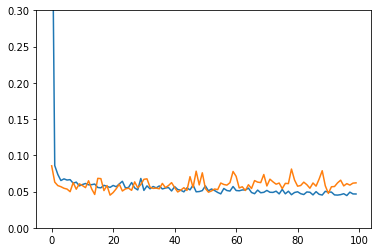

In [20]:
plt.ylim(0,0.3)
plt.plot(ly3.losses)
plt.plot(ly3.val_losses)

# 20번째 epoch에서 끝내줘도 될 것 같다.

In [21]:
# 훈련 조기종료하기
ly4 = SingleLayer_loss()
ly4.fit(x_train_scaled, y_train, epochs=20)
ly4.score(x_val_scaled, y_val)

0.978021978021978

### 가중치 규제

가중치의 값이 올라가지 않도록 하는 것. 

In [0]:
# l1, l2 회귀를 연습합니다.
# l1 적용하기 : w_grad += alpha * np.sigh(w)  (하이퍼 파라미터인 알파에 w의 부호를 곱함) -> lasso 라소 모델
# l2 적용하기 : w_grad += alpha * w (그냥 w만 곱해주면 됨) -> 릿지 모델

# Single layer 클래스에 손실함수에 대한 validation을 추가한다.

class SingleLayer_l1l2:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None  # weight 가중치
        self.b = None  # bias 바이어스
        self.losses = []  # 손실을 누적
        self.val_losses = [] # 검증 셋에 대한 손실을 기록
        self.w_history = []  # 가중치 변화 누적하는 리스트
        self.lr = learning_rate  # 학습률(hyperparameter)
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        # 정방향 진행
        z = np.sum(x * self.w) + self.b
        return z

    def backprop(self, x, error):
        # 역방향 진행
        w_g = x * error
        b_g = 1 * error
        return w_g, b_g

    def add_bias(self, x):
        # 1로 채워진 열백터를 추가하는. 
        return np.c_[np.ones((x.shape[0], 1)), x]

    def activation(self, z):
        # 활성화 함수
        a = 1 / (1 + np.exp(-z))
        return a 

    def fit(self, x, y, epochs=100, x_v=None, y_v=None):
        # 가중치랑 바이어스를 초기화
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())  # 가중치를 복사해서 기록(numpy 배열은 복사해서 넣어줘야 함)
        np.random.seed(42)  # 무작위로 시드 지정
        for i in range(epochs):
            loss = 0
            # 인덱스 섞기
            indexs = np.random.permutation(np.arange(len(x)))
            for j in indexs:
                z = self.forpass(x[j])  # 정방향 계산
                a = self.activation(z)  # 활성화 함수 적용
                err = -(y[j] - a)  # 오차 계산
                w_grad, b_grad = self.backprop(x[j], err)  # 역방향 계산
                # gradient에 페널티 항의 미분값을 더한다.
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w  # l1, l2 규제 업데이트
                self.w -= self.lr * w_grad  # 학습률을 곱해서 가중치 업데이트
                self.b -= b_grad
                self.w_history.append(self.w.copy())  # 가중치 기록
                a = np.clip(a, 1e-10, 1-1e-10)  # 로그 계산을 위한 클리핑
                loss += -(y[j]*np.log(a) + (1-y[j])*np.log(1-a))
            self.losses.append(loss/len(y))  # 평균 손실 저장
            self.updata_val_loss(x_v, y_v)  # 검증 셋에 대한 손실 계산

    def reg_loss(self):
        # 페널티 항에 대한 값을 더해야 한다. 
        return self.l1*np.sum(np.abs(self.w)) + self.l2/2 * np.sum(self.w**2)

    def updata_val_loss(self, x, y):
        # 검증 셋의 손실을 계산하기
        if x is None:
            return
        val_loss = 0
        for i in range(len(x)):
            z = self.forpass(x[i])  # 정방향 계산과 활성화 함수 적용
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))  # 동일하게 손실 계산
        self.val_losses.append(val_loss/len(y) + self.reg_loss()) # 여기에 페널티 계산

    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0

    def score(self, x, y):
        return np.mean(self.predict(x)==y)

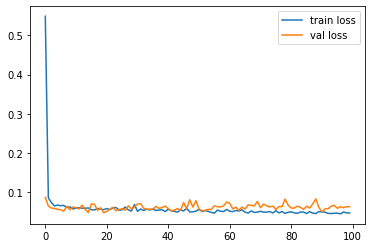

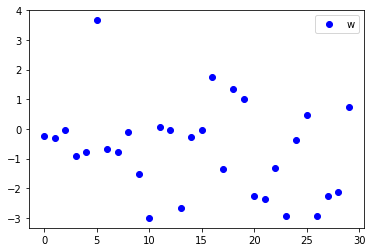

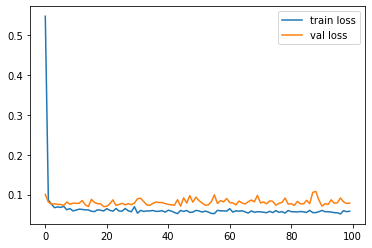

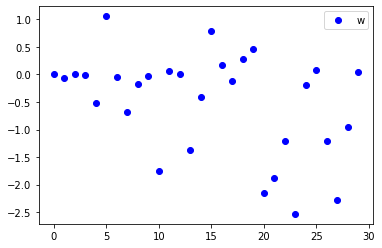

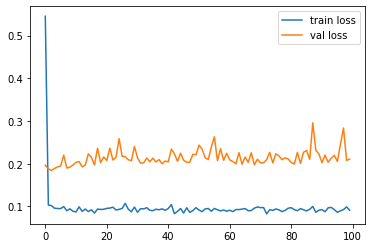

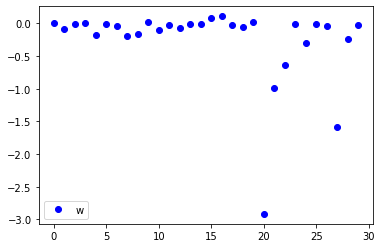

In [24]:
l1 = [0.0001, 0.001, 0.01]  # l1을 시킬 alpha를 골라주기

for alpha in l1:
    layer = SingleLayer_l1l2(l1=alpha)
    layer.fit(x_train_scaled, y_train, x_v = x_val_scaled, y_v=y_val)

    plt.plot(layer.losses)
    plt.plot(layer.val_losses)
    plt.legend(['train loss', 'val loss'])
    plt.show()

    plt.plot(layer.w, 'bo')
    plt.legend('weight')
    plt.show()

규제가 더 커질수록 훈련셋의 손실과 검증셋의 손실이 모두 높아지는 과소 적합 현상이 나타남

In [25]:
ly5 = SingleLayer_l1l2(l1=0.001)
ly5.fit(x_train_scaled, y_train, epochs=20)
ly5.score(x_val_scaled, y_val)

0.978021978021978

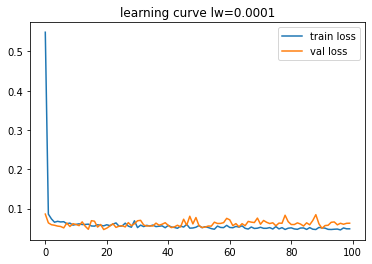

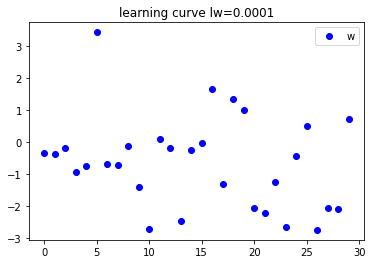

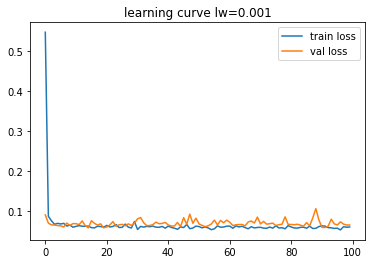

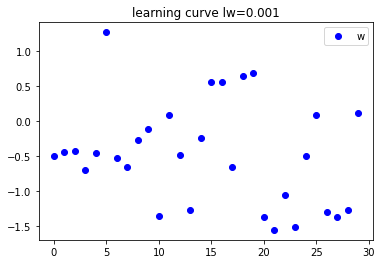

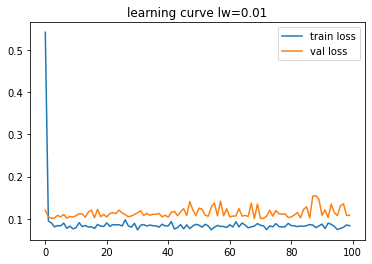

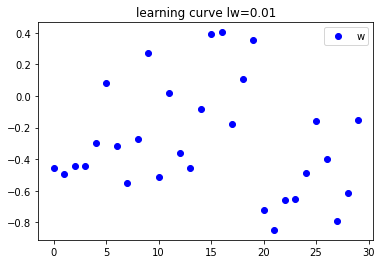

In [26]:
# l2 적용하기

l2 = [0.0001, 0.001, 0.01]  # l1을 시킬 alpha를 골라주기

for alpha in l1:
    layer = SingleLayer_l1l2(l2=alpha)
    layer.fit(x_train_scaled, y_train, x_v = x_val_scaled, y_v=y_val)

    plt.plot(layer.losses)
    plt.plot(layer.val_losses)
    plt.title('learning curve lw={}'.format(alpha))
    plt.legend(['train loss', 'val loss'])
    plt.show()

    plt.plot(layer.w, 'bo')
    plt.title('learning curve lw={}'.format(alpha))
    plt.legend('weight')
    plt.show()

l2 규제는 비슷한 양상을 보이지만, 규제 강도가 강해져도 l1 규제만큼 과소적합이 심해지진 않는다.

In [27]:
ly6 = SingleLayer_l1l2(l2=0.01)
ly6.fit(x_train_scaled, y_train, epochs=50)
ly6.score(x_val_scaled, y_val)

0.978021978021978

In [28]:
sdg = SGDClassifier(loss='log', penalty='l2', alpha=0.01, random_state=42)  # 모델 설정, l2 규제
sdg.fit(x_train_scaled, y_train)
sdg.score(x_val_scaled, y_val)

0.978021978021978

### 교차 검증

훈련 세트를 작은 덩어리(폴드)로 나누어서 진행

In [30]:
# 전체 데이터셋을 훈련셋과 테스트셋으로 1번만 나눈 것을 다시 사용하고, validation score 리스트를 만들기
validation_scores = []

# k-폴드 교차검증 : k 번의 교차검증
k = 10
bins = len(x_train) // k

for i in range(k):
    start = i*bins  # 시작, 끝을 정해주기
    end = (i+1)*bins
    val_fold = x_train_all[start:end]
    val_target = y_train_all[start:end]

    train_index = list(range(0, start)) + list(range(end, len(x_train)))  # [0 ---- start @@@@ end ---- 트레이닝 셋 끝까지]
    train_fold = x_train_all[train_index]
    train_target = y_train_all[train_index]

    train_mean = np.mean(train_fold, axis=0)
    train_std = np.std(train_fold, axis=0) # standard deviation을 계산
    train_fold_scaled = (train_fold - train_mean) / train_std
    val_fold_scaled = (val_fold - train_mean) / train_std  # 데이터 전처리도 같이해준다.

    lyr = SingleLayer_l1l2(l2=0.01)
    lyr.fit(train_fold_scaled, train_target, epochs=50)
    score = lyr.score(val_fold_scaled, val_target)
    validation_scores.append(score)

print(np.mean(validation_scores))


0.9583333333333333


In [31]:
from sklearn.model_selection import cross_validate

sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)  # 데이터의 표준화 전처리를 하지 않음
print(np.mean(scores['test_score']))

0.850096618357488


스킷런의 pipeline클래스를 활용해 sgd모델을 감싸서 cross validation을 시행한다.


In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), sgd)  # sgd 모델을 pipeline으로 감쌈
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9694202898550724
